# Scaling & Hyperparameter Tuning

![](https://i.ytimg.com/vi/b0L_2jKEbA4/maxresdefault.jpg)

In this notebook you will see a short example of how to scale your data and tune the hyperparamters of your models using grid or random search. 

We will use the well-known titanic dataset. Since you've already worked your way through the steps of exploring and cleaning the data as well as selecting proper features for modelling in another notebook, we will skip this part here and use the **preprocessed data** from the logistic regression notebook. 

In [15]:
# Import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

# eye candy plots
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
# source https://github.com/dhaitz/matplotlib-stylesheets

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

RSEED = 10

In [ ]:
!unzip data.zip

In [2]:
# Import data 
df = pd.read_csv('data/titanic_preprocessed.csv')
df.head()

,Survived,Age,SibSp,Parch,Fare,male,Q,S
0,0,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,1,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,0,35.0,0,0,8.0500,1,0,1


In [3]:
# Check for missing data
df.isnull().sum()

Survived    0
Age         0
SibSp       0
Parch       0
Fare        0
male        0
Q           0
S           0
dtype: int64

## Train-test-split

We will define the target and predictors and split our dataset into a train and test set.

In [4]:
# Define predictors and target
y = df.Survived
X = df.drop('Survived', axis=1)

In [5]:
# Check X
X.head(2)

,Age,SibSp,Parch,Fare,male,Q,S
0,22.0,1,0,7.2500,1,0,1
1,38.0,1,0,71.2833,0,0,0


In [6]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

---
## Feature Scaling

Often the input features of your model have different units which means that the variables also have different scales. While some model types (e.g. tree-based models like decision tree or random forest) are unaffected by the scale of numerical input variables, many machine learning algorithms including for example algorithms using distance measures (e.g. KNN, SVM) perform better when the input features are scaled to a specific range. 

The most popular techniques for scaling are **normalization** and **standardization**. 

Check the [link](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/) for further info. 

![](images/normalization_vs_standardization.png)

In [7]:
# Before we have a look at the different methods, 
# we have to define which columns we want to scale.
col_scale = ['Age', 'SibSp', 'Parch', 'Fare']

### Data Standardization 

In order to standardize a dataset it is necessary to rescale the distribution of values so that the mean of observed values is 0 and the standard deviation is 1. You can think of it as subtracting the mean value or centring the data. 
Sklearn provides us for this case with the [Standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

A value is standardized as follows: 

$ x_{scaled} = \frac{x – \mu}{\sigma}  $, where 

$ \mu = \frac{\sum{x}}{m} $ is the mean, where m is the number of observations

$ \sigma = \sqrt{ \frac{\sum{ (x – \mu)^2 }}{m}} $ is the standard deviation

In [8]:
# Scaling with standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale])
X_test_scaled = scaler.transform(X_test[col_scale])

In [9]:
# Concatenating scaled columns 
X_train_preprocessed = np.concatenate([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
X_test_preprocessed = np.concatenate([X_test_scaled, X_test.drop(col_scale, axis=1)], axis=1)

### Data normalization 

Normalizing the data means to rescale it from the original range so that all values lie within the new range of 0 and 1.
We can easily do this by using the [Min-Max-Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. This scaler transforms the feature(s) by scaling it(them) to a given range (default range is 0 to 1). 

A value is normalized as follows: 

$ x_{scaled} = \frac{x – x_{min}}{x_{max} – x_{min}} $

(Where the min and max values pertain to the value x being normalized, from your **train** dataset)

### ex1. Practice round
Try out doing normalizing

In [ ]:
# Scaling with MinMaxScaler

# Try to scale you data with the MinMaxScaler() from sklearn. 
# It follows the same syntax as the StandardScaler.
# Don't forget: you have to import the scaler at the top of your notebook. 

### Bonus Question: Do the test standardized / normalized values follow the same properties of the train standardized / normalized values?

i.e standardized: centered on 0 with stdev of 1 / normalized w values between 0 and 1

---
## Predictive Modelling

We will evaluate our model performance with a quick and more reliable way using sklearn's [cross_val_score()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) which implements K-fold cross validation. When training a model based on train and test split we only have one experiment. Can we really trust one experiment? 

Think of [K-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) as doing K experiments and then taking the average error. It is still not perfect but better than 1 experiment which can randomly turn out to be really good. 

Whenever we have K, comes the question about the value of K.. common values are between 5 and 10 and you need to take into account the technical limitations: dataset size, compute power and available memory and time. CV takes time on large datasets.


![](images/cross_validation.png)

### KNNClassifier - unscaled data

In [10]:
# Fit and evaluate model without hyperparameter tuning using cross validation and unscaled data 
knn_classifier = KNeighborsClassifier()
scores = cross_val_score(knn_classifier, X_train, y_train, cv=5, n_jobs=-1)

# Evaluation 
print('Score (unscaled):', round(scores.mean(), 4))

Score (unscaled): 0.6934


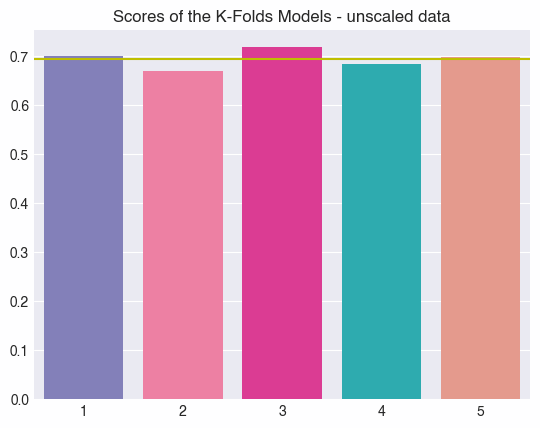

In [11]:
# plotting the scores and average score
plt.axhline(y=scores.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=scores).set_title('Scores of the K-Folds Models - unscaled data');

### KNNClassifier - scaled data

In [12]:
# Fit and evaluate model without hyperparameter tuning using cross validation and scaled data 
knn_classifier_scaled = KNeighborsClassifier()
scores_scaled = cross_val_score(knn_classifier_scaled, X_train_preprocessed, y_train, cv=5, n_jobs=-1)

# Evaluation
print('Score (scaled):', round(scores_scaled.mean(), 4))

Score (scaled): 0.789


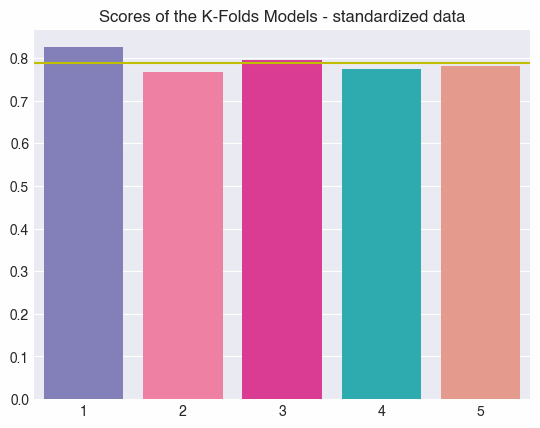

In [13]:
plt.axhline(y=scores_scaled.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=scores_scaled).set_title('Scores of the K-Folds Models - standardized data');

You can see that the overall error has gone down significantly (in my case an increase of 13% in the evaulation score), but the errors of the folds are rather similar to each. To show the effect of scaling a bit clearer we will look at another classifier that is even more affected by it.  

### SGDClassifier - unscaled data

SGD classifier stands for stochastic gradient descent classifier and implements a variety of classifiers - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html. The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM). We will use it here to further emphasise the importance of scaling and will set the loss parameter to `log_loss`. This way the model will be a logistic regression using stochastic gradient descent for learning.

In [85]:
# Fit and evaluate model without hyperparameter tuning using cross validation and unscaled data 
sgd_classifier = SGDClassifier(random_state=RSEED, loss ='log_loss')
scores = cross_val_score(sgd_classifier, X_train, y_train, cv=5, n_jobs=-1)

# Evaluation 
print('Score (unscaled):', round(scores.mean(), 4))

Score (unscaled): 0.6399


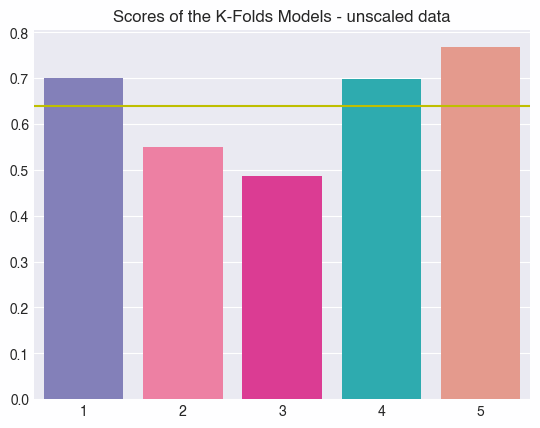

In [92]:
# plotting the scores and average score
plt.axhline(y=scores.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=scores).set_title('Scores of the K-Folds Models - unscaled data');

The validation error varies a lot for the different folds of the data (from around 0.5 to a high of almost 0.8)

In [95]:
# Fit and evaluate model without hyperparameter tuning using cross validation and scaled data 
sgd_classifier_scaled = SGDClassifier(random_state=RSEED,loss ='log_loss')
scores_scaled = cross_val_score(sgd_classifier_scaled, X_train_preprocessed, y_train, cv=5, n_jobs=-1)

# Evaluation
print('Score (scaled):', round(scores_scaled.mean(), 4))

Score (scaled): 0.782


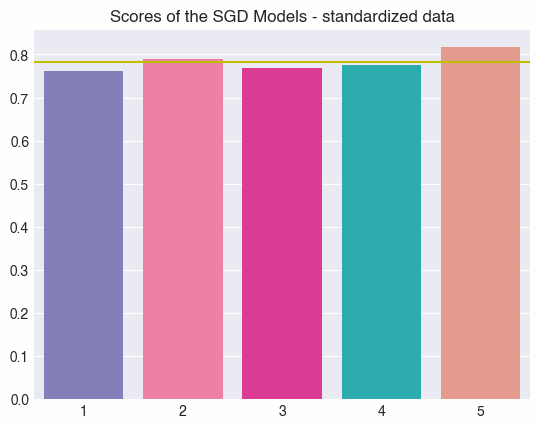

In [96]:
plt.axhline(y=scores_scaled.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=scores_scaled).set_title('Scores of the SGD Models - standardized data');

Beside the obviously better overall performance an important effect of scaling visible here is that the validation error doesn't vary quite as much as it used with most of the values being closer to the 0.8 mark. 

### ex2. Practice round
Try out KNNClassifier with the normalized data

In [ ]:
# Train model using the MinMaxScaler data you scaled in ex1.

# It follows the same syntax as the StandardScaler.

---
## Hyperparameter Tuning

Most models have many parameters that work better with some datasets than with others. Same goes with the parameters from regularization which we learned that are selected based on a trial and error process. So how do we manage to select the parameter values that work best for our data?

#### GridSearchCV

[Grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is a tuning technique that attempts to compute the optimum values of hyperparameters. It performs an exhaustive search over a prior defined parameter space using cross-validation (hence the **CV** suffix). That means it will evaluate all of the possible parameter combinations of the search space in order to find and return the best combination. 


This task, however, starts to become very time-consuming if there are many hyperparameters and the search space is huge. As you can see for k= 5 and for 2 parameters with 2, and respectively 3 values, thus 6 combinations, the GridSearchCV runs 30 modelling steps in order to just come up with the best values for the two parameters.

![](images/grid_search_cv.png)

In [ ]:
#what parameters does KNN have?
knn_classifier.get_params().keys()

In [ ]:
# Defining parameter grid (as dictionary)
param_grid = {"n_neighbors" : [2,4,3,5,10], #this actually defines the model you use
              "weights" : ["uniform", "distance"],
              "p" : [1, 2, 3],
              "algorithm": ["ball_tree", "kd_tree", "brute"]
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
start = timer()
gs.fit(X_train_preprocessed, y_train)
end = timer()
gs_time = end-start

In [ ]:
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

In [ ]:
# we will do this at least twice.. according to DRY we should write a function
def print_pretty_summary(name, model, y_test, y_pred_test):
    print(name)
    print('=======================')
    print('n_neighbors: {}'.format(model.n_neighbors))
    print('weights: {}'.format(model.weights))
    print('p: {}'.format(model.p))
    print('algorithm: {}'.format(model.algorithm))

    accuracy = accuracy_score(y_test, y_pred_test)
    print('Test accuracy: {:2f}'.format(accuracy))
    return accuracy

In [ ]:
# Assigning the fitted KNNClassifier model with best parameter combination to a new variable knn_best
knn_best = gs.best_estimator_

# Making predictions on the test set
y_pred_test = knn_best.predict(X_test_preprocessed)
# Let us print out the performance of our model on the test set.
knn_accuracy = print_pretty_summary('KNNClassifier model', knn_best, y_test, y_pred_test)

#### [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

As an alternative to grid search we can use sklearn's RandomizedSearchCV(). Random search will not try every possible combination of our search space but will randomly pick and evaluate parameter combinations. 

In [ ]:
# Define parameter grid for randomized search
param_grid = {"n_neighbors" : [2,4,3,5,10], #this actually defines the model you use
              "weights" : ["uniform", "distance"],
              "p" : [1, 2, 3],
              "algorithm": ["ball_tree", "kd_tree", "brute"]
             }

# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state=RSEED)

# Fit randomized search object to data
start = timer()
rs.fit(X_train_preprocessed, y_train)
end = timer()
rgs_time = end-start

In [ ]:
# Best score
print('Best score:', round(rs.best_score_, 3))

# Best parameters
print('Best parameters:', rs.best_params_)

In [ ]:
# Assigning the fitted KNNClassifier model with best parameter combination to a new variable knn_best
knn_best_rs = rs.best_estimator_

# Making predictions on the test set
y_pred_test_rs = knn_best_rs.predict(X_test_preprocessed)


# Let us print out the performance of our model on the test set.
rknn_accuracy = print_pretty_summary('KNNClassifier model (randomizedGSCV)', knn_best_rs, y_test, y_pred_test_rs)

In [ ]:
print(f"Grid search took {gs_time} seconds to run with accuracy: {knn_accuracy:f}")
print(f"Randomized Grid search took {rgs_time} seconds to run with accuracy: {rknn_accuracy:f}")

This is an educational example... more data means longer train times